# F21NL 2025-26: Word Embeddings

Content of this tutorial is delivered during the 'F20NL/F21NL - Introduction to Natural Language Processing' course at Heriot-Watt University.

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:**

1. The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

2. These embeddings are indexed via *token ids* -- integers that convert strings to a machine readable format. Think of tokens ids as a simple mapping between strings and integers that allow for a model to use in its calculations, and then decoded back into a human-readable format.

In [ ]:
!pip install gensim datasets numpy -U

In [ ]:
# This is required for plotting the figures within an interactive jupyter notebook
%matplotlib inline

import pprint
import matplotlib.pyplot as plt

import random
import re
import gensim.downloader as api
import numpy as np
import scipy as sp

from datasets import load_dataset
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA

imdb_dataset = load_dataset("stanfordnlp/imdb", name="plain_text")

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NUM_SAMPLES = 150

np.random.seed(0)
random.seed(0)

plt.rcParams['figure.figsize'] = [10, 5]

## What is preprocessing?

<div align="center">

lab0 (1).svg

<div align="center">

Preprocessing is simply the term used for different transformations that human-readable text go through before being turned into word tokens. This is necessary, as the string "Hello", unless transformed somehow, would not map into the same token (and embedding), as the string "hello".

1. Preprocessing can be broken down into multiple steps such as:

2. Normalisation (Stripping accents, making strings lowercase, removing spaces, etc.).

3. Splitting tokens by a unique identifier (AKA tokenization).

4. Handling missing values / general data cleaning.


It is important to note that changes on this level will impact a model's perception of the text. For example the normalization process cannot be reversed. This essentially means that the model might never encounter the word "Hello", only "hello" if the data is transformed in lowercase. Failing to take account of this effect can lead to models training suboptimally or not showing results in data outside of that seen in training!

In [3]:
toy_data = [
    "Word embed£££ings are a type of word repres$$@£entation that allows for           word!!!s to be represented as individual vectors in a continuous vECTor space.",
    "Every word is     map!!!!ped to one vecTOR and the ve$$@$$@ctor values are learned in a way that resembles a neu$$@ral network,      so the vectors capture many subtle linguistic properties.",
    "Vectors can indicate the similarity      bet,,ween WorDs, and be used to derive rela!!!!!!!tionships between words.",
    "But vectors can also be used to map for semantic and contextual similarities between words.",
    "Word embeDDings can be extra!!cted from      large corpuses of text, although bigger is not always better, as      text quality can impact on embeDDings!",
]

In [4]:
def normalize_text(text: str) -> str:
    """Normalize text by removing special characters, extra spaces, and converting to lowercase. """
    # Remove special characters manually
    cleaned_text = "".join(char for char in text if char.isalnum() or char.isspace())
    # Remove extra spaces
    cleaned_text = " ".join(cleaned_text.split())
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text


def normalize_dataset(dataset: list[str]) -> list[str]:
    """Normalize a dataset of text strings."""
    cleaned_data = [normalize_text(sentence) for sentence in dataset]
    # return cleaned data
    return cleaned_data

cleaned_data = normalize_dataset(toy_data)

## Part 1: Count-Based Word Vectors

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://web.archive.org/web/20190530091127/https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"



|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

In NLP, we commonly use start and end tokens (`<START>`, `<END>`) to mark the beginning and end of sentences, paragraphs, or documents. These tokens are included in co-occurrence counts, encapsulating each document, for example: "`<START>` All that glitters is not gold `<END>`".

The matrix rows (or columns) provide word vectors based on word-word co-occurrence, but they can be large. To reduce dimensionality, we employ Principal Component Analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), selecting the top $k$ principal components.

If you are not familiar with PCA, we recommend having a look [here](https://www.youtube.com/watch?v=Pka3-LaeUvw&list=PLBv09BD7ez_4InDh85LM_43Bsw0cFDHdN&ab_channel=VictorLavrenko).
On a high-level PCA will try to identify the directions within the embedding space that preserve as much variance as possible. As a result, this dimensionality reduction maintains semantic relationships; for instance, *doctor* and *hospital* will be closer than *doctor* and *dog*.

In [5]:
def read_corpus() -> list[list[str]]:
    """ Read files from the Large Movie Review Dataset.

    Return a list of tokenised reviews, each review is a list of words.
    """
    files = imdb_dataset["train"]["text"][:NUM_SAMPLES]
    # Return a list of lists, where each sub-list is a tokenized review with start and end tokens
    return [f"{START_TOKEN} {normalize_text(line)} {END_TOKEN}".split(" ") for line in files]

In [ ]:
imdb_corpus = read_corpus()
pprint.pprint(imdb_corpus[:3], compact=True, width=100)
print("corpus size: ", len(imdb_corpus[0]))

### Exercise 1: Implement `distinct_words`


Write a method to work out the distinct words (word types) that occur in the corpus.

You can use `for` loops to process the input `corpus` (a list of list of strings), but try using Python list comprehensions (which are generally faster). In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

In [ ]:
def distinct_words(corpus: list[list[str]]) -> tuple[list[str], int]:
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    raise NotImplementedError("Implement distinct_words()")

### Exercise 2: Implement `compute_co_occurrence_matrix`

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.

In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    raise NotImplementedError("Implement compute_co_occurrence_matrix()")

In [9]:
# Run this as a sanity check
test_corpus = [
    "{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "),
    "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")
]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

print("Passed All Tests! :)")

Passed All Tests! :)


### Exercise 3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use PCA to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** Have a look at [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [ ]:
def reduce_to_k_dim(M: np.ndarray, k: int = 2) -> np.ndarray:
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) PCA:

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
    """
    raise NotImplementedError("Implement reduce_to_k_dim()")

Here we plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

Note that this is a minimal example. In the future and for your plots, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [11]:
def plot_embeddings(M_reduced: np.ndarray, word2ind: dict[str, int], words: list[str]) -> None:
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".

        Note: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    plt.figure()
    for word in words:
        if word in word2ind:
            idx = word2ind[word]
            x, y = M_reduced[idx]
            plt.scatter(x, y, label=word)
        else:
            print(f"{word} was not found in vocabulary")

    plt.legend()
    plt.xlim(-1.25, 1.25)
    plt.ylim(-1.25, 1.25)
    plt.title("Word Embeddings Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

Co-occurrence matrix shape:  (5878, 5878)
Reduced matrix shape:  (5878, 2)


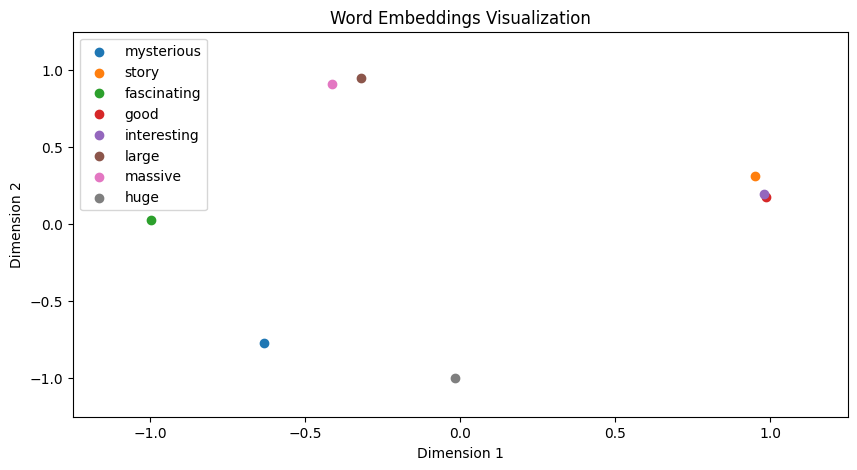

In [12]:
# Compute co-occurrence matrix for the imdb corpus
M_co_occurrence, word2ind = compute_co_occurrence_matrix(imdb_corpus, window_size=4)
print("Co-occurrence matrix shape: ", M_co_occurrence.shape)

# Reduce to 2D using PCA
M_reduced = reduce_to_k_dim(M_co_occurrence, k=2)
print("Reduced matrix shape: ", M_reduced.shape)

# Plot embeddings for a few words
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
# Broadcasting
M_normalized = M_reduced / M_lengths[:, np.newaxis]

words = ['mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']
plot_embeddings(M_normalized, word2ind, words)

## Part 2: Prediction-Based Word Vectors

More recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [word2vec's original paper](https://arxiv.org/pdf/1301.3781).




**Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [13]:
def load_embedding_model(embeddings_name: str = "glove-wiki-gigaword-200") -> KeyedVectors:
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All embeddings, each length 200
    """
    wv_from_bin = api.load(embeddings_name)
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [14]:
def get_matrix_of_vectors(wv_from_bin: KeyedVectors, required_words: list[str]) -> tuple[np.ndarray, dict[str, int]]:
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the Word2Vec vectors loaded from file
            required_words: list of strings corresponding to required words
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.shuffle(words)
    print("Putting %i words into word2ind and matrix M..." % len(words))

    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        if w in wv_from_bin.key_to_index:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1

    for w in required_words:
        if w in words or w not in wv_from_bin.key_to_index:
            continue

        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = curInd
        curInd += 1

    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [ ]:
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
# Broadcasting
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis]

plot_embeddings(M_reduced_normalized, word2ind, words)

## Further reading

In this lab we explored word vectors from the perspective of co-occurences and learnable representations.

We recommend having a look at the Gensim libary more in detail as we will use it in the first coursework. In particular:

* [Core concepts in Gensim](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py)
* [Corpora and vector spaces](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html#sphx-glr-auto-examples-core-run-corpora-and-vector-spaces-py)


## Acknolwedgements

This notebook is based on existing learning material for including:

* [CS224N: Natural Language Processing with Deep Learning](https://web.stanford.edu/class/cs224n/)
* [Athens NLP Summer School](https://github.com/athnlp)